In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # для стилизации графиков
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

### Знакомство с методом k-средних

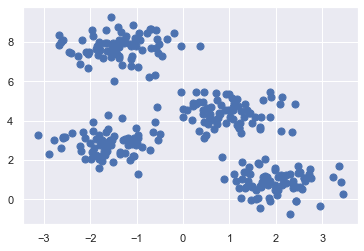

In [2]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [64]:
X

array([[1.3300000e+00, 6.4236620e+04, 1.0367400e+03, ..., 8.6036200e+03,
        9.3250000e+01, 0.0000000e+00],
       [1.3500000e+00, 5.4876980e+04, 6.7428000e+02, ..., 9.4080700e+03,
        9.7490000e+01, 0.0000000e+00],
       [9.3000000e-01, 1.1822022e+05, 7.9470000e+02, ..., 8.0422100e+03,
        1.0314000e+02, 0.0000000e+00],
       ...,
       [1.8700000e+00, 1.3766760e+04, 1.1919200e+03, ..., 9.3518000e+03,
        4.2310000e+01, 0.0000000e+00],
       [1.9300000e+00, 1.6205220e+04, 1.5276300e+03, ..., 1.0919540e+04,
        5.0000000e+01, 0.0000000e+00],
       [1.6200000e+00, 1.7489580e+04, 2.8947700e+03, ..., 1.1988140e+04,
        2.6010000e+01, 0.0000000e+00]])

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

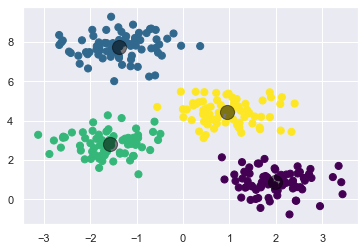

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Алгоритм k-средних: максимизация математического ожидания

##### Алгоритм k-средних

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
	# 1. Выбираем кластеры случайным образом
	rng = np.random.RandomState(rseed)
	i = rng.permutation(X.shape[0])[:n_clusters]
	centers = X[i]
	while True:
		# 2a. Присваиваем метки в соответствии с ближайшим центром
		labels = pairwise_distances_argmin(X, centers)
		# 2b. Находим новые центры, исходя из средних значений точек
		new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
		# 2c. Проверяем сходимость
		if np.all(centers == new_centers):
			break
		centers = new_centers
	
	return centers, labels

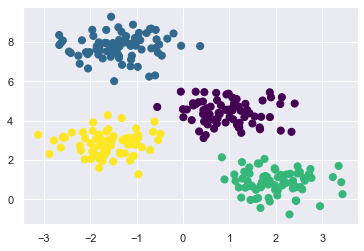

In [6]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Пример неудачной кластеризации при неудачной начальной инициализации центральных величин

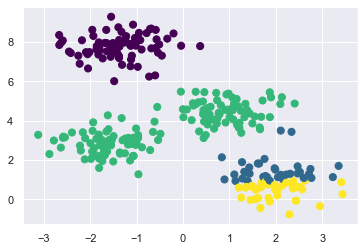

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

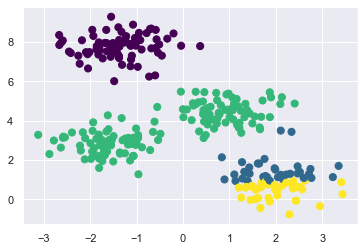

In [8]:
abels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### Пример неправильной работы Kmeans в случае нелинейных границ

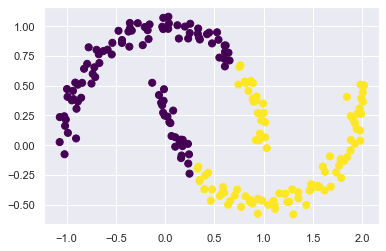

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### SpectralClustering

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


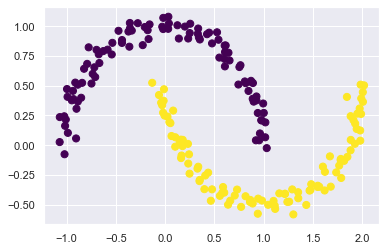

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### Пример 1: применение метода k-средних для рукописных цифр

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

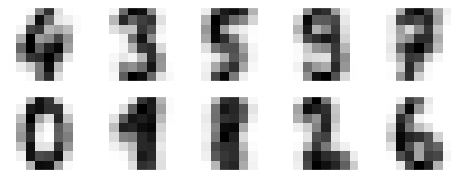

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
	axi.set(xticks=[], yticks=[])
	axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [56]:
clusters, len(clusters)

(array([3, 2, 2, ..., 8, 9, 8]), 1797)

In [54]:
from scipy.stats import mode
labels = np.zeros_like(clusters)

for i in range(10):
	mask = (clusters == i)
	labels[mask] = mode(digits.target[mask])[0]

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

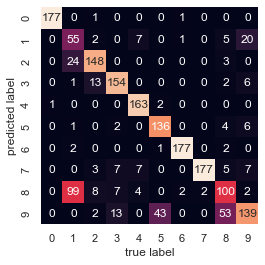

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Алгоритм стохастического вложениясоседей на основе распределения Стьюдента (t-SNE)

In [17]:
from sklearn.manifold import TSNE
# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data) # Расчет кластеров
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj) # Перестановка меток местами
labels = np.zeros_like(clusters)

for i in range(10):
	mask = (clusters == i)
	labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, labels)

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.9432387312186978

### Пример 2: использование метода k-средних для сжатия цветов

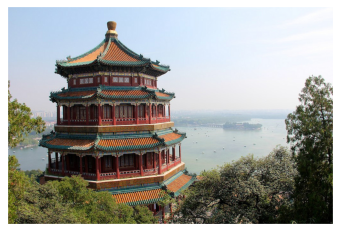

In [18]:
# Обратите внимание: для работы этого кода
# должен быть установлен пакет pillow
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [19]:
china.shape

(427, 640, 3)

In [20]:
data = china / 255.0 # используем шкалу 0...1
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
	if colors is None:
		colors = data
		# Выбираем случайное подмножество
		rng = np.random.RandomState(0)
		i = rng.permutation(data.shape[0])[:N]
		colors = colors[i]
		R, G, B = data[i].T
		fig, ax = plt.subplots(1, 2, figsize=(16, 6))
		ax[0].scatter(R, G, color=colors, marker='.')
		ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
		ax[1].scatter(R, B, color=colors, marker='.')
		ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
		fig.suptitle(title, size=20);

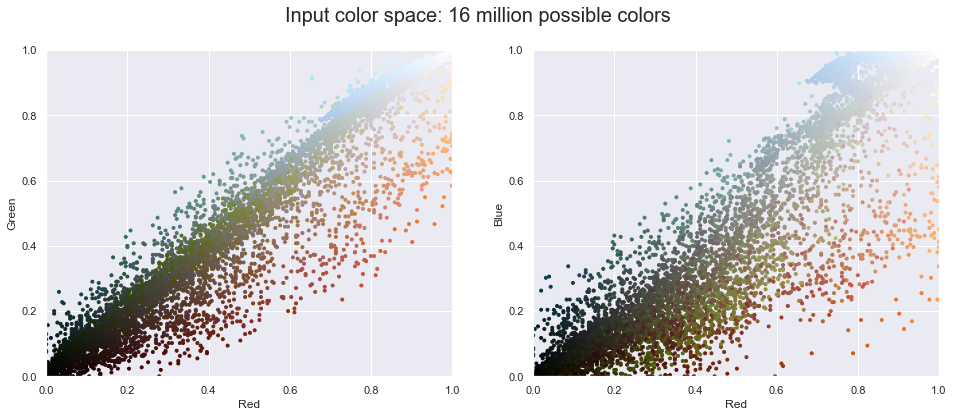

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

##### уменьшим количество цветов с 16 миллионов до 16 путемкластеризацииметодом k-средних на пространстве пикселов

In [23]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

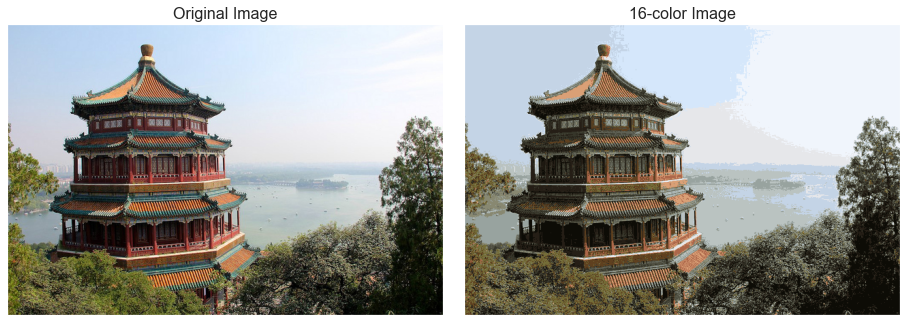

In [24]:
china_recolored = new_colors.reshape(china.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16) # Первоначальное изображение
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16); # 16-цветное изображение

## Собственный датасет

Я буду использовать датасет взятый отсюда https://www.kaggle.com/datasets/neuromusic/avocado-prices

Сначала я буду пытаться сделать кластеры по регионам на основе имеющихся покупок и цен

In [132]:
avocado_dataset = pd.read_csv("./avocado.csv")

In [133]:
avocado_dataset.head(10)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
5,5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,conventional,2015,Albany
6,6,2015-11-15,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,conventional,2015,Albany
7,7,2015-11-08,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,conventional,2015,Albany
8,8,2015-11-01,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,conventional,2015,Albany
9,9,2015-10-25,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,conventional,2015,Albany


In [134]:
avocado_dataset['region'].value_counts().head()

Albany                338
Sacramento            338
Northeast             338
NorthernNewEngland    338
Orlando               338
Name: region, dtype: int64

In [135]:
avocado_dataset['type'].value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [136]:
avocado_dataset = avocado_dataset.drop(columns=['Date', "Unnamed: 0", 'year', 'type'])
avocado_dataset

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,region
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,Albany
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,Albany
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,Albany
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,Albany
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,Albany
...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,WestTexNewMexico
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,WestTexNewMexico
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,WestTexNewMexico
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,WestTexNewMexico


## Convert labels

In [137]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(avocado_dataset['region'].values)

label_encoder.classes_

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [138]:
X = avocado_dataset.drop(columns=['region']).values
y = label_encoder.transform(avocado_dataset['region'].values)

In [139]:
len(label_encoder.classes_)

54

In [140]:
kmeans = Pipeline([
	('Normalizer', Normalizer()), 
	('KMeans', KMeans(n_clusters=len(label_encoder.classes_), random_state=0))
])
clusters = kmeans.fit_predict(X)

In [106]:
from scipy.stats import mode
labels = np.zeros_like(clusters)

for i in range(len(label_encoder.classes_)):
	mask = (clusters == i)
	labels[mask] = mode(y[mask])[0]

In [107]:
accuracy_score(y, labels)

0.20549071181982576

In [81]:
0.1419803824867116

0.1419803824867116

## tnse

In [141]:
from sklearn.manifold import TSNE
# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=3, init='pca', random_state=0)
X = Normalizer().fit_transform(X)
digits_proj = tsne.fit_transform(X) # Расчет кластеров
kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=0)
clusters = kmeans.fit_predict(digits_proj) # Перестановка меток местами
labels = np.zeros_like(clusters)

for i in range(len(label_encoder.classes_)):
	mask = (clusters == i)
	labels[mask] = mode(y[mask])[0]

accuracy_score(y, labels)

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.22691654337223957

In [82]:
0.14570661406104443

0.14570661406104443

In [109]:
0.22691654337223957

0.22691654337223957

## Теперь попробуем использовать другой признак из того же датасета

In [110]:
avocado_dataset = pd.read_csv("./avocado.csv")

In [111]:
avocado_dataset.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [112]:
avocado_dataset = avocado_dataset.drop(columns=['Date', "Unnamed: 0", 'year', 'region'])

In [113]:
avocado_dataset

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional
...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic


In [115]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(avocado_dataset['type'].values)

label_encoder.classes_

array(['conventional', 'organic'], dtype=object)

In [120]:
X = avocado_dataset.drop(columns=['type']).values
y = label_encoder.transform(avocado_dataset['type'].values)

In [116]:
kmeans = Pipeline([
	('Normalizer', Normalizer()), 
	('KMeans', KMeans(n_clusters=len(label_encoder.classes_), random_state=0))
]) 
clusters = kmeans.fit_predict(X)

from scipy.stats import mode
labels = np.zeros_like(clusters)

for i in range(len(label_encoder.classes_)):
	mask = (clusters == i)
	labels[mask] = mode(y[mask])[0]

accuracy_score(y, labels)

0.7188339087073264

## tnse

In [121]:
from sklearn.manifold import TSNE
# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=2, init='pca', random_state=0)
X = Normalizer().fit_transform(X)
digits_proj = tsne.fit_transform(X) # Расчет кластеров
kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=0)
clusters = kmeans.fit_predict(digits_proj) # Перестановка меток местами
labels = np.zeros_like(clusters)

for i in range(len(label_encoder.classes_)):
	mask = (clusters == i)
	labels[mask] = mode(y[mask])[0]

accuracy_score(y, labels)

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.5554824921913529